# <font color='Tomato'>Planejamento da Solução (IOT)</font>

## Input - Entrada

### O problema de negócio

1. Selecionar os mais valiosos clientes para formar o programa de fidelidade "INSIDERS"
2. Conjunto de dados com as vendas de produtos durantes 1 ano (11/2015 - 12/2017)

## Output - Saída
 
1. A indicação de pessoas para fazer parte do programa de fidelidade "INSIDERS".
2. Relatório com as respostas das perguntas de negocio.

## Tasks - Processo

# 0.0. Imports

In [133]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import umap.umap_ as umap

from IPython.display import HTML
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from sklearn import cluster
from sklearn import metrics
from sklearn import preprocessing as pp

## 0.1. Helper Functions

In [134]:
def descriptive_statistics(num_attr):
    # Central Tendency: mean, median
    c1 = pd.DataFrame(num_attr.apply(np.mean))
    c2 = pd.DataFrame(num_attr.apply(np.median))

    # Dispension: min, max, range, std, skew, kurtosis
    d1 = pd.DataFrame(num_attr.apply(min))
    d2 = pd.DataFrame(num_attr.apply(max))
    d3 = pd.DataFrame(num_attr.apply(lambda x: x.max() - x.min()))
    d4 = pd.DataFrame(num_attr.apply(lambda x: x.std()))
    
    # Measures of Shape
    s1 = pd.DataFrame(num_attr.apply(lambda x: x.skew()))
    s2 = pd.DataFrame(num_attr.apply(lambda x: x.kurtosis()))

    # concat
    m = pd.concat([d1,d2,d3,c1,c2,d4,s1,s2], axis=1).reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    return m


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Load Data

In [135]:
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='latin1')

# drop extra column
df_raw = df_raw.drop('Unnamed: 8', axis=1)

# 1.0. Data Description

In [136]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [137]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data Dimnesions

In [138]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 541909
Number of Columns: 8


## 1.3. Data Types

In [139]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [140]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [141]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [142]:
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge 
df1 = pd.merge(df1, df_backup, how='left', on='invoice_no' )

# coalesce 
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

df1 = df1.drop(['customer_id_x', 'customer_id_y'], axis=1)

In [143]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6. Change dtypes

In [144]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [145]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])

## 1.7. Descriptive Statistics

In [146]:
num_att = df1.select_dtypes(include=['int64', 'float64'])
cat_att = df1.select_dtypes(include=['object'])

## 1.7.1. Numerical Attributes

In [147]:
descriptive_statistics(num_att)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.00,161990.00,9.55,3.00,218.08,-0.26,119769.16
1,unit_price,-11062.06,38970.00,50032.06,4.61,2.08,96.76,186.51,59005.72
2,customer_id,12346.00,22709.00,10363.00,16688.84,16249.00,2911.41,0.49,-0.80


**Notes:**
    
1. quantity: numero negativo e alto, pode ser retorno
2. unit_price: zero unidades? 

## 1.7.2. Categorical Attributes

In [148]:
cat_att.describe(include=['O'])

,invoice_no,stock_code,description,country
count,541909,541909,540455,541909
unique,25900,4070,4223,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,1114,2313,2369,495478


### invoice_no

In [149]:
list_letter_invoice = df1.loc[~df1['invoice_no'].apply(lambda x: bool(re.search(r'^[0-9]+', x))), 'invoice_no'].tolist()
len(list_letter_invoice)

9291

In [150]:
list_letter_invoice[:10]

['C536379',
 'C536383',
 'C536391',
 'C536391',
 'C536391',
 'C536391',
 'C536391',
 'C536391',
 'C536391',
 'C536506']

### stock_code

In [151]:
list_letter_stock_code = df1.loc[~df1['stock_code'].apply(lambda x: bool(re.search(r'[^a-zA-Z]+$', x))), 'stock_code'].tolist()

len(list_letter_stock_code)

54675

### country

In [152]:
df1['country'].value_counts(normalize=True).head(10)

United Kingdom   0.91
Germany          0.02
France           0.02
EIRE             0.02
Spain            0.00
Netherlands      0.00
Belgium          0.00
Switzerland      0.00
Portugal         0.00
Australia        0.00
Name: country, dtype: float64

**Notes**
1. invoice_no: 8905 items que não são somente numeros.
2. stock_code: 35809 items que não são somente numeros.
3. description: não tem informação relevante.

# 2.0. Data Filtering

In [153]:
df2 = df1.copy()

## 2.1. Filter Columns

In [154]:
cols_drop = ['description']
df2 = df2.drop(cols_drop, axis=1)

## 2.2. Filter Rows

In [155]:
# Numerical Attributes
df2 = df2.loc[df2['unit_price'] >= 0.4, :]

# Categorical Attributes
df2 = df2.loc[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ), :]

# map
df2 = df2.loc[~df2['country'].isin(['European Community', 'Unspecified' ]), :]

# bad users
df2 = df2[~df2['customer_id'].isin( [16446] )]

# quantity
df2_returns   = df2.loc[df2['quantity'] < 0, :]
df2_purchases = df2.loc[df2['quantity'] >= 0, :]

# 3.0. Feature Engineering

In [156]:
df3 = df2.copy()

## 3.1. Feature Creation

In [157]:
drop_cols = ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country']
df_ref = df3.drop(drop_cols, axis=1).drop_duplicates(ignore_index=True)

In [158]:
df2_purchases.loc[:, ['gross_revenue']] = (df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price'])

/home/cid/.pyenv/versions/3.8.0/envs/clustering-high-value-customers-identification/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


### 3.1.1. Monetary

In [159]:
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index().rename(columns={'gross_revenue': 'monetary'})
df_ref = pd.merge(df_ref, df_monetary, how='left', on='customer_id')
df_ref.isna().sum()

customer_id     0
monetary       92
dtype: int64

### 3.1.2. Recency

In [160]:
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df_recency['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_ref = pd.merge(df_ref, df_recency[['customer_id', 'recency_days']], how='left', on='customer_id')

df_ref.isna().sum()

customer_id      0
monetary        92
recency_days    92
dtype: int64

### 3.1.3. Frequency

In [161]:
df_freq = df2_purchases.loc[:, ['customer_id', 'invoice_no']].\
                        drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no': 'frequency'})
df_ref = pd.merge(df_ref, df_freq, how='left', on='customer_id')
df_ref.isna().sum()

customer_id      0
monetary        92
recency_days    92
frequency       92
dtype: int64

### 3.1.4. Average Ticket

In [162]:
df_avg_ticket = df2_purchases.loc[:, ['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, how='left', on='customer_id')

df_ref.isna().sum()

customer_id      0
monetary        92
recency_days    92
frequency       92
avg_ticket      92
dtype: int64

# 4.0. EDA  

In [163]:
df_ref = df_ref.dropna()

In [164]:
df4 = df_ref.copy()

# 5.0. Data Preparation 

In [165]:
df5 = df4.copy()

In [166]:
ss = pp.StandardScaler()

df5['monetary'] = ss.fit_transform(df5[['monetary']])
df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
df5['frequency'] = ss.fit_transform(df5[['frequency']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])

# 6.0. Feature Selection

In [167]:
df6 = df5.copy()

# 7.0. Hyperpameter Fine Tuning

In [168]:
X = df6.drop(columns=['customer_id'])

In [169]:
X.head()

,monetary,recency_days,frequency,avg_ticket
0,0.49,2.28,4.50,-0.03
1,0.20,-0.55,0.82,-0.03
2,0.64,-1.03,1.70,-0.01
3,-0.11,-0.20,0.23,-0.01
4,-0.12,1.93,-0.07,0.24


In [170]:
clusters = [2,3,4,5,6,7]

## KMeans

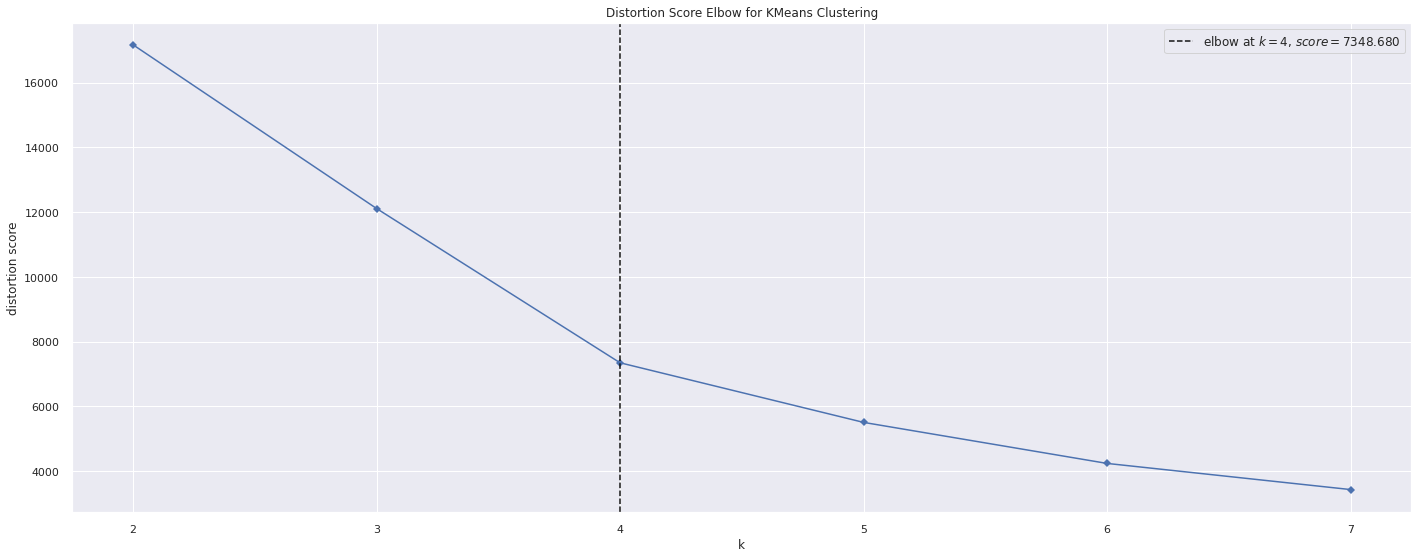

In [171]:
kmeans = KElbowVisualizer(cluster.KMeans(), k=clusters, timings=False)
kmeans.fit( X )
kmeans.show();

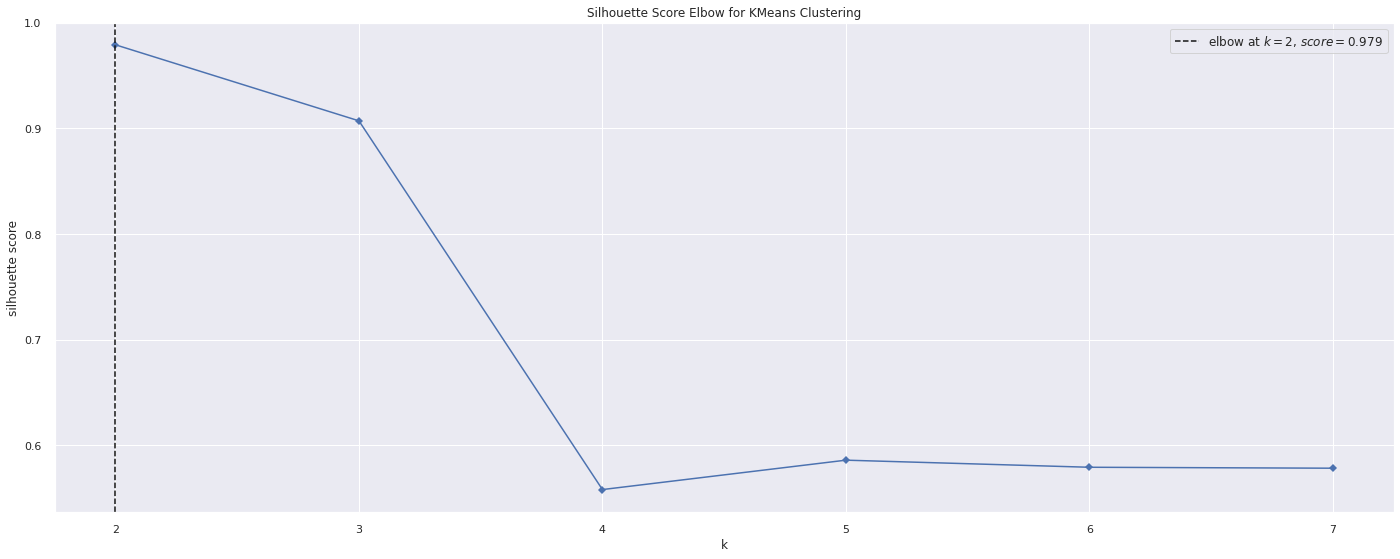

In [172]:
km = KElbowVisualizer(cluster.KMeans(), k=clusters, metric='silhouette', timings=False)
km.fit( X )
km.show();

## 7.1. Silhouette Analysis

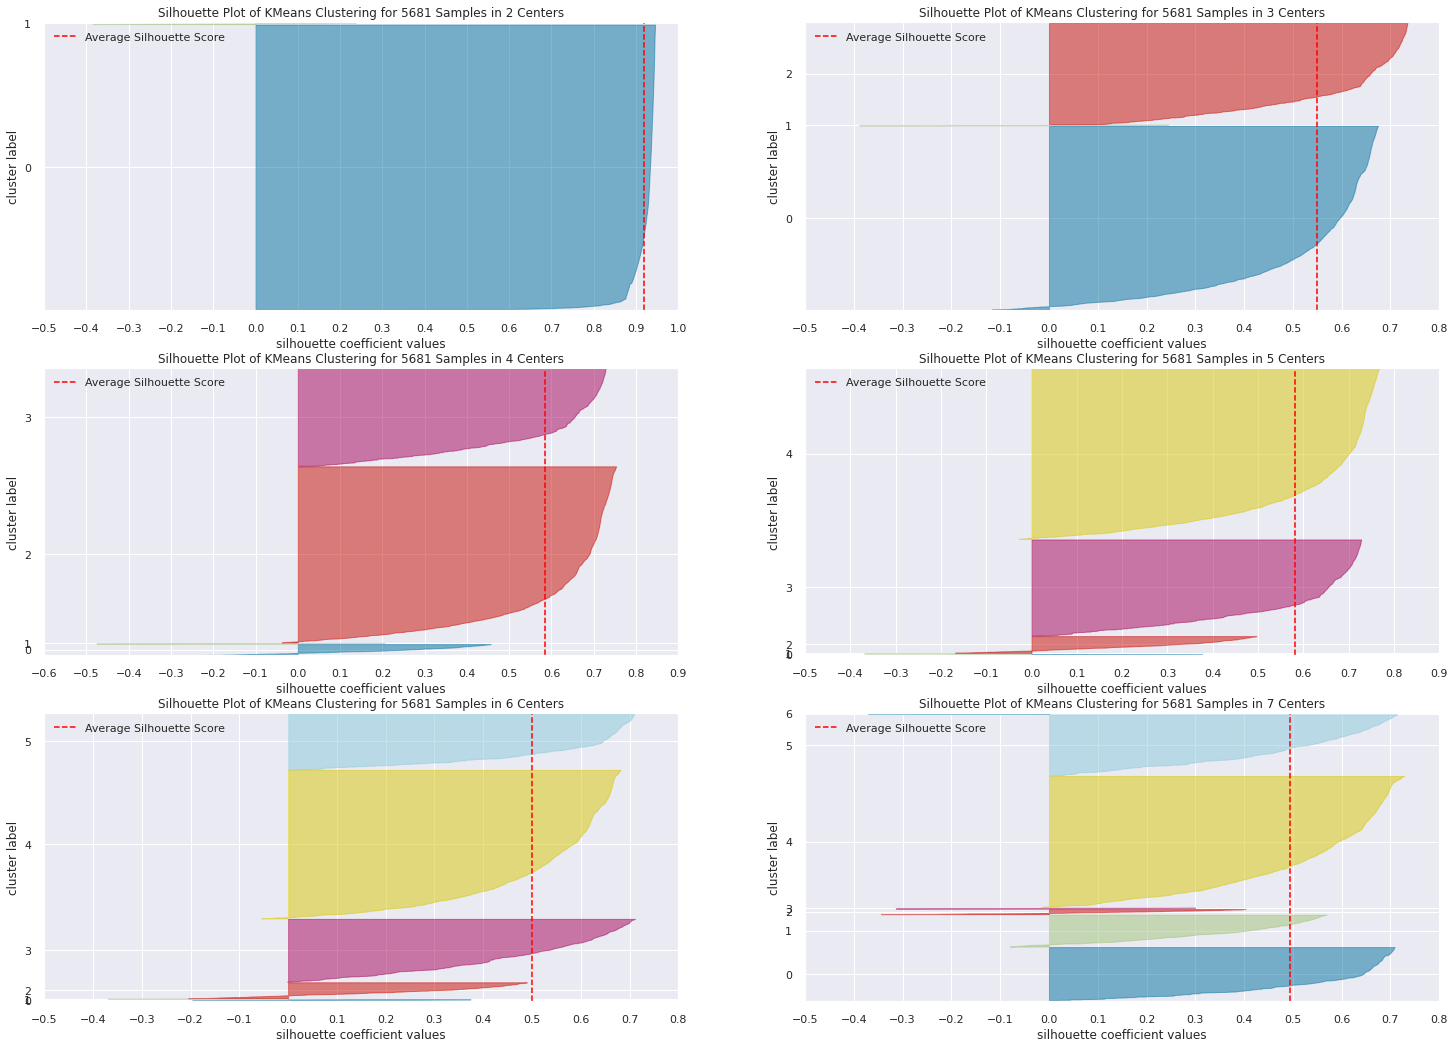

In [173]:
fig, ax = plt.subplots(3,2, figsize=(25, 18))

for k in clusters:
    km = cluster.KMeans(n_clusters=k, init='random', n_init=10, random_state=42)
    q, mod = divmod(k, 2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit( X )
    visualizer.finalize();

# 8.0. Model Training

## 8.1. K-Means

In [174]:
# model definition
k = 4
kmeans = cluster.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300)

# model training
kmeans.fit( X )

# clustering
labels = kmeans.labels_

## 8.2. Cluster Validation

In [175]:
metrics.silhouette_score(X, labels, metric='euclidean')

0.5827546788141622

In [176]:
print('WSS value: {}'.format( kmeans.inertia_ ))
print('SS value: {}'.format( metrics.silhouette_score(X, labels, metric='euclidean') ))

WSS value: 10595.112397940638
SS value: 0.5827546788141622


# 9.0. Cluster Analysis

In [177]:
df9 = df4.copy()
df9['cluster'] = labels
df9.head()

,customer_id,monetary,recency_days,frequency,avg_ticket,cluster
0,17850.00,5391.21,372.00,34.00,18.15,1
1,13047.00,3232.59,56.00,9.00,18.90,2
2,12583.00,6495.30,2.00,15.00,29.39,2
3,13748.00,938.89,95.00,5.00,34.77,2
4,15100.00,876.00,333.00,3.00,292.00,3


## 9.1. Visualization Inspection

### 9.1.1. Silhouette Analysis

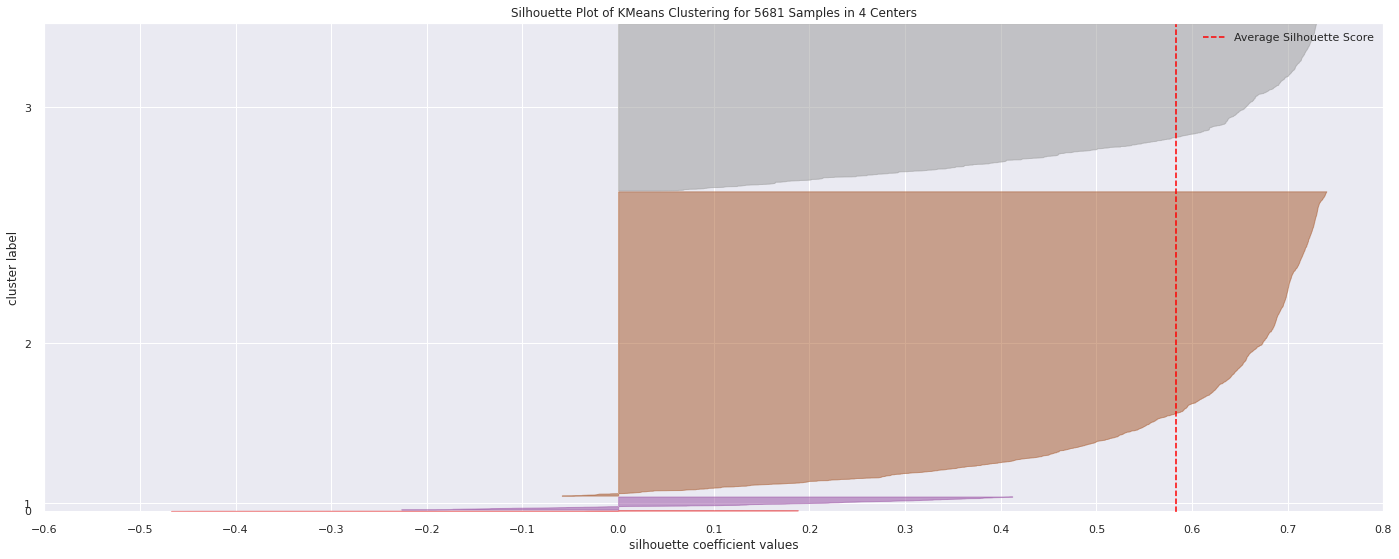

In [178]:
visualizer = SilhouetteVisualizer(kmeans, color='yellowbrick')
visualizer.fit( X )
visualizer.finalize();

### 9.1.2 2d plot

In [179]:
df_viz = df9.drop(columns='customer_id')

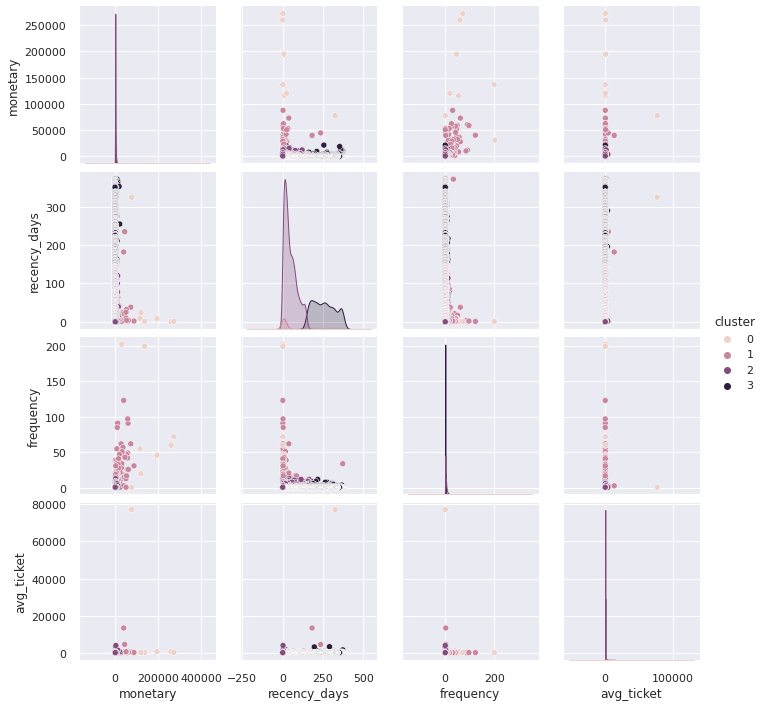

In [180]:
sns.pairplot(df_viz, hue='cluster');

### 9.1.3. UMAP

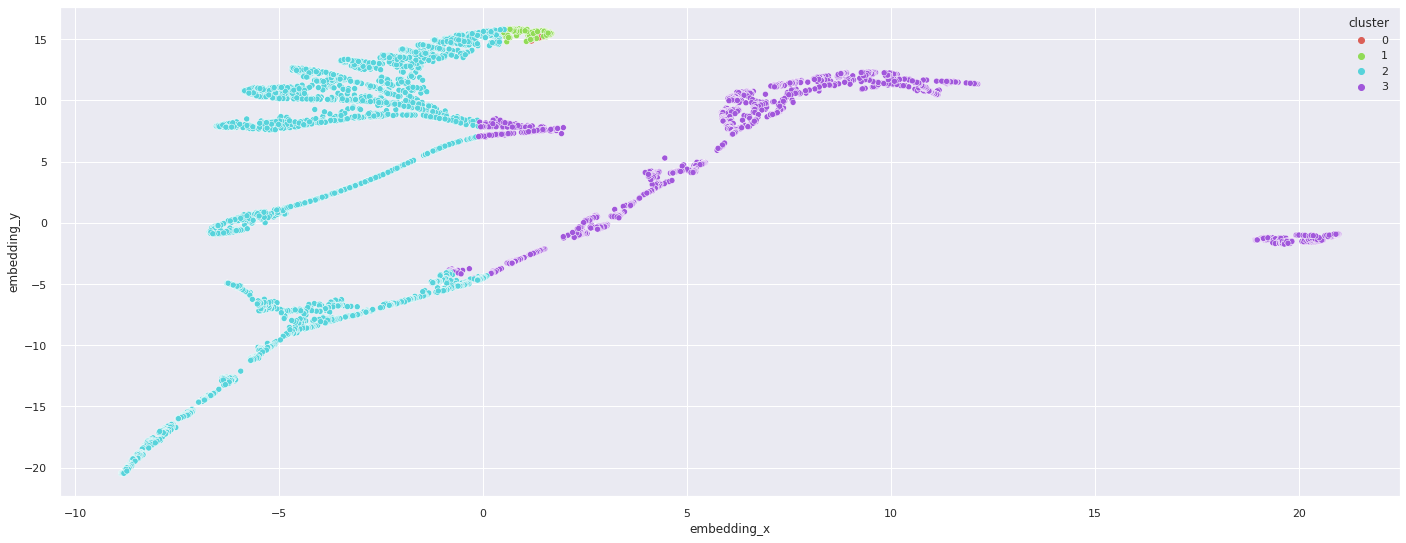

In [181]:
reducer = umap.UMAP(n_neighbors=80, random_state=42)
embedding = reducer.fit_transform( X )

df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 hue='cluster', 
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
                 data=df_viz );

## 9.2. Cluster Profile

In [182]:
df9.head()

,customer_id,monetary,recency_days,frequency,avg_ticket,cluster
0,17850.00,5391.21,372.00,34.00,18.15,1
1,13047.00,3232.59,56.00,9.00,18.90,2
2,12583.00,6495.30,2.00,15.00,29.39,2
3,13748.00,938.89,95.00,5.00,34.77,2
4,15100.00,876.00,333.00,3.00,292.00,3


In [183]:
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index().rename(columns={'customer_id': 'qt_users'})

# gross_revenue
gross_revenue = df9[['monetary', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, gross_revenue, how='left', on='cluster')

df_cluster['per_user'] = 100 * (df_cluster['qt_users'] / df_cluster['qt_users'].sum())
# recency_days
recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, recency_days, how='left', on='cluster')

# recency_days
frequency = df9[['frequency', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'invoice_no': 'frequency'})
df_cluster = pd.merge(df_cluster, frequency, how='left', on='cluster')


df_cluster

,cluster,qt_users,monetary,per_user,recency_days,frequency
0,0,8,150905.25,0.14,46.00,81.88
1,1,152,16265.67,2.68,13.26,26.88
2,2,3565,1398.28,62.75,46.28,3.49
3,3,1956,641.01,34.43,254.52,1.28


# 10.0. Deploy to Product